## Imports

In [21]:
try:
    from einops import rearrange
    import segmentation_models_pytorch as smp
    from timm.models.layers import drop_path, trunc_normal_
    
except:
    !pip install timm
    !pip install einops
    !pip install segmentation-models-pytorch
    
    from einops import rearrange
    import segmentation_models_pytorch as smp
    from timm.models.layers import drop_path, trunc_normal_

In [1]:
# basic imports
import random
import numpy as np
import os

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting 
import cv2
import matplotlib.pyplot as plt

In [2]:
# try to import the library, if already present 
# good to go, else install it and then import library
try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

## 1. Dataset

In [3]:
dataset_path = '../dataset/'
output_path = '../output/'

In [4]:
DATA_DIR = "../../data/Potsdam/patches/500px"

x_train_dir = os.path.join(DATA_DIR, 'rgb')
y_train_dir = os.path.join(DATA_DIR, 'label')

x_valid_dir = os.path.join(DATA_DIR, 'rgb_valid')
y_valid_dir = os.path.join(DATA_DIR, 'label_valid')

x_test_dir = os.path.join(DATA_DIR, 'rgb_test')
y_test_dir = os.path.join(DATA_DIR, 'label_test')

In [5]:
impervious = [255, 255, 255]
building = [0, 0, 255]
vegetation = [0, 255, 255]
tree = [0, 255, 0]
car = [255, 255, 0]
clutter = [255, 0, 0]

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == impervious,axis=-1)] = 0
    label_seg [np.all(label==building,axis=-1)] = 1
    label_seg [np.all(label==vegetation,axis=-1)] = 2
    label_seg [np.all(label==tree,axis=-1)] = 3
    label_seg [np.all(label==car,axis=-1)] = 4
    label_seg [np.all(label==clutter,axis=-1)] = 5
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

In [6]:
from torchvision import transforms

preprocess = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
                ])

In [7]:
# from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['impervious', 'building', 'vegetation', 'tree', 'car', 'clutter']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            patch_size=512
    ):
        self.im_ids = os.listdir(images_dir) 
        # self.im_ids = list(filter(lambda x: x.endswith('11_RGB.tif'), self.im_ids))
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.im_ids]
        self.mask_ids = os.listdir(masks_dir) 
        # self.mask_ids = list(filter(lambda x: x.endswith('11_label.tif'), self.mask_ids))
        self.masks_fps = [os.path.join(masks_dir, mask_id) for mask_id in self.mask_ids]
        
        self.dims = (patch_size, patch_size)
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.dims, interpolation=cv2.INTER_NEAREST)
        mask = cv2.imread(self.masks_fps[i])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB) # cv2 reads image as BGR, change to RGB
        mask = cv2.resize(mask, self.dims, interpolation=cv2.INTER_NEAREST)
        mask = rgb_to_2D_label(mask)
        # print(self.images_fps[i])
        
        # # extract certain classes from mask (e.g. cars)
        # masks = [(mask == v) for v in self.class_values]
        # mask = np.stack(masks, axis=-1).astype('float')
        # if len(self.class_values) < len(self.CLASSES):
        #     mask = np.c_[np.zeros((np.shape(mask)[0], np.shape(mask)[1], 1)), mask] # add column to make everything not in selected classes background
        mask = torch.from_numpy(mask).long()
        
        # # apply augmentations
        # if self.augmentation:
        #     sample = self.augmentation(image=image, mask=mask)
        #     image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            image = self.preprocessing(image)
            
        return image, mask
        
    def __len__(self):
        return len(self.im_ids)

#### Dataloaders

- Dataloaders help load data in batches
- We'll need to define separate dataloaders for training, validation and test sets



In [8]:
from torch.utils.data import DataLoader

# train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)
CLASSES=['impervious', 'building', 'vegetation', 'tree', 'car', 'clutter']

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    # augmentation=get_training_augmentation(), 
    preprocessing=preprocess,
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    # augmentation=get_validation_augmentation(), 
    preprocessing=preprocess,
    classes=CLASSES,
)

test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    # augmentation=get_validation_augmentation(), 
    preprocessing=preprocess,
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)#, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)#, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)#, num_workers=4)

### Show Sample images from dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


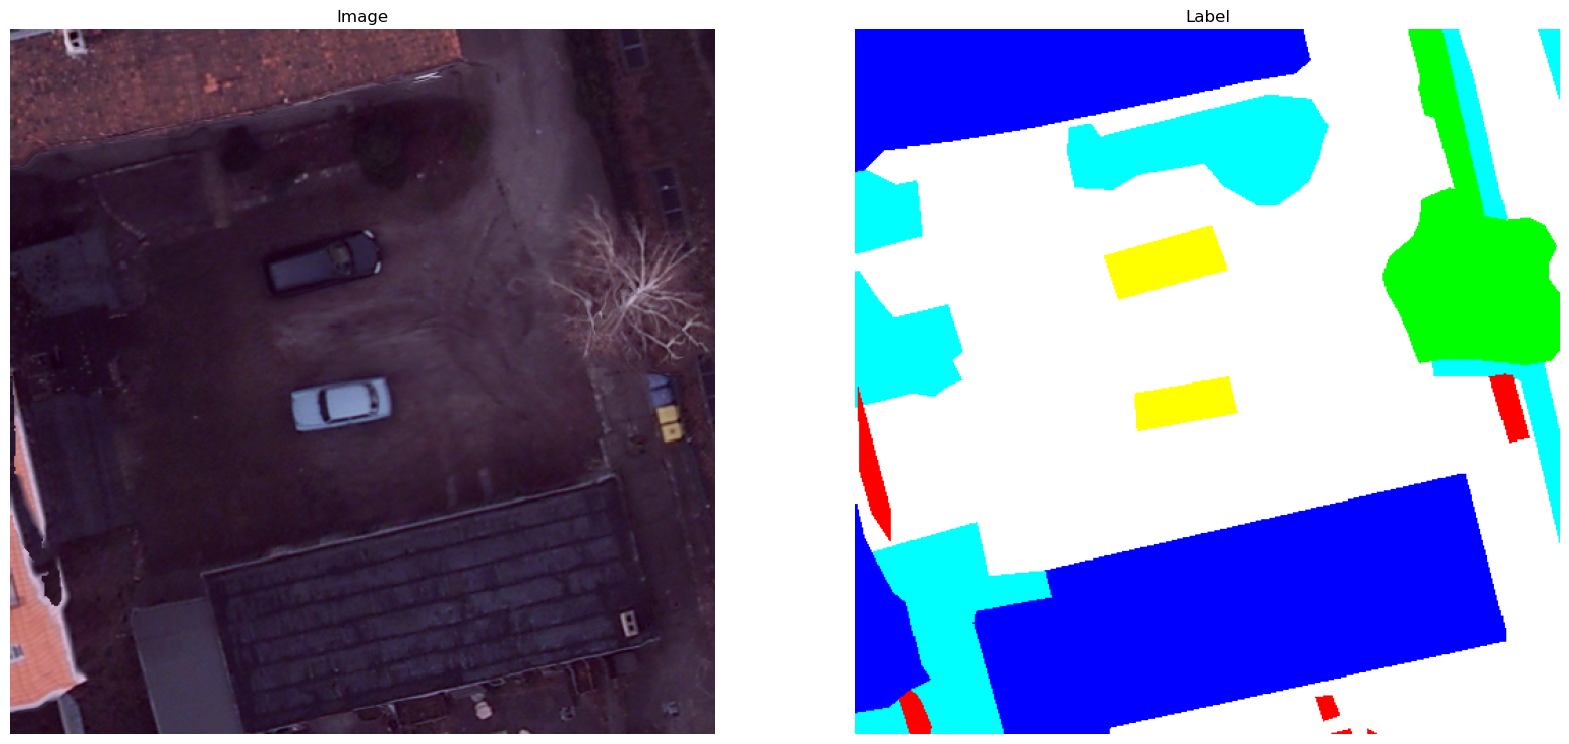

In [9]:
from utils import inverse_transform, train_id_to_color

rgb_image, label = train_dataset[np.random.choice(len(train_dataset))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

## 2. Network

In [10]:
class overlap_patch_embed(nn.Module):
    def __init__(self, patch_size, stride, in_chans, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size // 2, patch_size // 2))
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = self.proj(x)
        _, _, h, w = x.shape
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.norm(x)
        return x, h, w

In [11]:
class mix_feedforward(nn.Module):
    def __init__(self, in_features, out_features, hidden_features, dropout_p = 0.0):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.fc2 = nn.Linear(hidden_features, out_features)
        
        # Depth-wise separable convolution
        self.conv = nn.Conv2d(hidden_features, hidden_features, (3, 3), padding=(1, 1),
                              bias=True, groups=hidden_features)
        self.dropout_p = dropout_p
        
    def forward(self, x, h, w):
        x = self.fc1(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        x = self.conv(x)
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = F.gelu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        return x
        

In [12]:
class efficient_self_attention(nn.Module):
    def __init__(self, attn_dim, num_heads, dropout_p, sr_ratio):
        super().__init__()
        assert attn_dim % num_heads == 0, f'expected attn_dim {attn_dim} to be a multiple of num_heads {num_heads}'
        self.attn_dim = attn_dim
        self.num_heads = num_heads
        self.dropout_p = dropout_p
        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(attn_dim, attn_dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(attn_dim)

        # Multi-head Self-Attention using dot product
        # Query - Key Dot product is scaled by root of head_dim
        self.q = nn.Linear(attn_dim, attn_dim, bias=True)
        self.kv = nn.Linear(attn_dim, attn_dim * 2, bias=True)
        self.scale = (attn_dim // num_heads) ** -0.5

        # Projecting concatenated outputs from 
        # multiple heads to single `attn_dim` size
        self.proj = nn.Linear(attn_dim, attn_dim)


    def forward(self, x, h, w):
        q = self.q(x)
        q = rearrange(q, ('b hw (m c) -> b m hw c'), m=self.num_heads)

        if self.sr_ratio > 1:
            x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
            x = self.sr(x)
            x = rearrange(x, 'b c h w -> b (h w) c')
            x = self.norm(x)

        x = self.kv(x)
        x = rearrange(x, 'b d (a m c) -> a b m d c', a=2, m=self.num_heads)
        k, v = x[0], x[1] # x.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = attn @ v
        x = rearrange(x, 'b m hw c -> b hw (m c)')
        x = self.proj(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        return x

In [13]:
class transformer_block(nn.Module):
    def __init__(self, dim, num_heads, dropout_p, drop_path_p, sr_ratio):
        super().__init__()
        # One transformer block is defined as :
        # Norm -> self-attention -> Norm -> FeedForward
        # skip-connections are added after attention and FF layers
        self.attn = efficient_self_attention(attn_dim=dim, num_heads=num_heads, 
                    dropout_p=dropout_p, sr_ratio=sr_ratio)
        self.ffn = mix_feedforward( dim, dim, hidden_features=dim * 4, dropout_p=dropout_p)                    

        self.drop_path_p = drop_path_p
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        

    def forward(self, x, h, w):
        # Norm -> self-attention
        skip = x
        x = self.norm1(x)
        x = self.attn(x, h, w)
        x = drop_path(x, drop_prob=self.drop_path_p, training=self.training)
        x = x + skip

        # Norm -> FeedForward
        skip = x
        x = self.norm2(x)
        x = self.ffn(x, h, w)
        x = drop_path(x, drop_prob=self.drop_path_p, training=self.training)
        x = x + skip
        return x

In [14]:
class mix_transformer_stage(nn.Module):
    def __init__(self, patch_embed, blocks, norm):
        super().__init__()
        self.patch_embed = patch_embed
        self.blocks = nn.ModuleList(blocks)
        self.norm = norm

    def forward(self, x):
        x, h, w = self.patch_embed(x)
        for block in self.blocks:
            x = block(x, h, w)
        x = self.norm(x)
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)
        return x

In [15]:
class mix_transformer(nn.Module):
    def __init__(self, in_chans, embed_dims, num_heads, depths, 
                sr_ratios, dropout_p, drop_path_p):
        super().__init__()
        self.stages = nn.ModuleList()
        for stage_i in range(len(depths)):
            # Each Stage consists of following blocks :
            # Overlap patch embedding -> mix_transformer_block -> norm
            blocks = []
            for i in range(depths[stage_i]):
                blocks.append(transformer_block(dim = embed_dims[stage_i],
                        num_heads= num_heads[stage_i], dropout_p=dropout_p,
                        drop_path_p = drop_path_p * (sum(depths[:stage_i])+i) / (sum(depths)-1),
                        sr_ratio = sr_ratios[stage_i] ))

            if(stage_i == 0):
                patch_size = 7
                stride = 4
                in_chans = in_chans
            else:
                patch_size = 3
                stride = 2
                in_chans = embed_dims[stage_i -1]
            
            patch_embed = overlap_patch_embed(patch_size, stride=stride, in_chans=in_chans, 
                            embed_dim= embed_dims[stage_i])
            norm = nn.LayerNorm(embed_dims[stage_i], eps=1e-6)
            self.stages.append(mix_transformer_stage(patch_embed, blocks, norm))
            

    def forward(self, x):
        outputs = []
        for stage in self.stages:
            x = stage(x)
            outputs.append(x)
        return outputs

In [16]:
class segformer_head(nn.Module):
    def __init__(self, in_channels, num_classes, embed_dim, dropout_p=0.1):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.dropout_p = dropout_p

        # 1x1 conv to fuse multi-scale output from encoder
        self.layers = nn.ModuleList([nn.Conv2d(chans, embed_dim, (1, 1))
                                     for chans in reversed(in_channels)])
        self.linear_fuse = nn.Conv2d(embed_dim * len(self.layers), embed_dim, (1, 1), bias=False)
        self.bn = nn.BatchNorm2d(embed_dim, eps=1e-5)

        # 1x1 conv to get num_class channel predictions
        self.linear_pred = nn.Conv2d(self.embed_dim, num_classes, kernel_size=(1, 1))
        self.init_weights()

    def init_weights(self):
        nn.init.kaiming_normal_(self.linear_fuse.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.bn.weight, 1)
        nn.init.constant_(self.bn.bias, 0)

    def forward(self, x):
        feature_size = x[0].shape[2:]
        
        # project each encoder stage output to H/4, W/4
        x = [layer(xi) for layer, xi in zip(self.layers, reversed(x))]
        x = [F.interpolate(xi, size=feature_size, mode='bilinear', align_corners=False)
             for xi in x[:-1]] + [x[-1]]
        
        # concatenate project output and use 1x1
        # convs to get num_class channel output
        x = self.linear_fuse(torch.cat(x, dim=1))
        x = self.bn(x)
        x = F.relu(x, inplace=True)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.linear_pred(x)
        return x

In [17]:
class segformer_mit_b3(nn.Module):    
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Encoder block    
        self.backbone = mix_transformer(in_chans=in_channels, embed_dims=(64, 128, 320, 512), 
                                    num_heads=(1, 2, 5, 8), depths=(3, 4, 18, 3),
                                    sr_ratios=(8, 4, 2, 1), dropout_p=0.0, drop_path_p=0.1)
        # decoder block
        self.decoder_head = segformer_head(in_channels=(64, 128, 320, 512), 
                                    num_classes=num_classes, embed_dim=256)

    def forward(self, x):
        image_hw = x.shape[2:]
        x = self.backbone(x)
        x = self.decoder_head(x)
        x = F.interpolate(x, size=image_hw, mode='bilinear', align_corners=False)
        return x

Nice work! Let's now train this model!

## 3. Training : Train and validate model on the custom dataset

In [18]:
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

### Hyperparameters

In [19]:
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
# device = 'cpu'
print(device)

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

# reference : https://smp.readthedocs.io/en/latest/losses.html
# criterion = smp.losses.DiceLoss('multiclass', log_loss = True, smooth=1.0)
criterion = smp.losses.JaccardLoss('multiclass', log_loss = False, smooth=0.0)

# MODEL HYPERPARAMETERS
N_EPOCHS = 20
NUM_CLASSES = 6
MAX_LR = 3e-4
# MODEL_NAME = 'UNet_baseline_jaccardloss'

# create model, optimizer, lr_scheduler and pass to training function
# model = UNet(in_channels=3, out_channels=NUM_CLASSES, layer_channels=[64, 128, 256, 512]).to(device)
model = segformer_mit_b3(in_channels=3, num_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS, steps_per_epoch = len(train_loader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

cuda:0


In [ ]:
from utils import IoU
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

MODEL_NAME = 'Segformer_baseline_jaccardloss_noScheduler'

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
                         device, train_loader, valid_loader, IoU, 'metrices',
                         NUM_CLASSES, lr_scheduler = None, output_path = output_path)

../output/Segformer_baseline_jaccardloss_noScheduler/Segformer_baseline_jaccardloss_noScheduler_last.pt
Starting 1 epoch ...


100%|██████████| 720/720 [06:32<00:00,  1.84it/s]


Epoch: 1, trainLoss:0.75582, validationLoss:0.54423, validation_metrices: {'accuracy': 0.6332317405276828, 'classwise_accuracy': array([0.77441559, 0.60098828, 0.67322079, 0.47080013, 0.68176871,
       0.11564172]), 'miou': 0.39010006951306675, 'classwise_iou': array([0.59904177, 0.5698252 , 0.44949322, 0.27900902, 0.37718554,
       0.06604567])}, ttainingDuration: 0:35:24.887771
best model saved
Starting 2 epoch ...


100%|██████████| 720/720 [01:49<00:00,  6.56it/s]


Epoch: 2, trainLoss:0.63412, validationLoss:0.48771, validation_metrices: {'accuracy': 0.7048051993052165, 'classwise_accuracy': array([0.74475087, 0.83370047, 0.80807434, 0.41113667, 0.65562766,
       0.14487265]), 'miou': 0.4682303961878187, 'classwise_iou': array([0.62353163, 0.67245763, 0.55565204, 0.32687574, 0.55193124,
       0.0789341 ])}, ttainingDuration: 0:17:34.389921
best model saved
Starting 3 epoch ...


100%|██████████| 720/720 [01:46<00:00,  6.78it/s]


Epoch: 3, trainLoss:0.57093, validationLoss:0.44989, validation_metrices: {'accuracy': 0.7373820887671576, 'classwise_accuracy': array([0.73694581, 0.84090795, 0.81457973, 0.58907773, 0.72332442,
       0.16614567]), 'miou': 0.5133303083852698, 'classwise_iou': array([0.6426784 , 0.7039403 , 0.58749102, 0.43463219, 0.60718252,
       0.10405741])}, ttainingDuration: 0:08:52.715366
best model saved
Starting 4 epoch ...


  1%|          | 9/1008 [00:05<10:10,  1.64it/s]

# Tests

In [21]:
# MODEL_NAME = 'UNet_baseline_test
MODEL_PATH = os.path.join(output_path,MODEL_NAME, MODEL_NAME+'_last.pt')
print(MODEL_PATH)
# model_jacc = UNet(in_channels=3, out_channels=NUM_CLASSES, layer_channels=[64, 128, 256, 512]).to(device) 

checkpoint = torch.load(MODEL_PATH)
# model_jacc.load_state_dict(checkpoint_jacc['model_state_dict'])

print(checkpoint['results'])

../output/UNet_baseline_jaccardloss_noScheduler/UNet_baseline_jaccardloss_noScheduler_last.pt
[{'epoch': 0, 'trainLoss': 0.6875752947988019, 'validationLoss': 0.46485907484149924, 'metrices': {'accuracy': 0.7370470099978976, 'classwise_accuracy': array([0.82922774, 0.72049965, 0.83570588, 0.59148755, 0.65480001,
       0.13563145]), 'miou': 0.5100709113799263, 'classwise_iou': array([0.644523  , 0.66050817, 0.59164414, 0.47880685, 0.60152722,
       0.08341608])}, 'duration_train': datetime.timedelta(seconds=383, microseconds=602980)}, {'epoch': 1, 'trainLoss': 0.569661047605295, 'validationLoss': 0.42489130144208, 'metrices': {'accuracy': 0.7622094896104601, 'classwise_accuracy': array([0.82585281, 0.79560166, 0.87592784, 0.55608263, 0.81428066,
       0.16462087]), 'miou': 0.5479616837690883, 'classwise_iou': array([0.67621182, 0.70933986, 0.61349064, 0.48617407, 0.69542289,
       0.10713082])}, 'duration_train': datetime.timedelta(seconds=378, microseconds=72908)}, {'epoch': 2, 'tr

../output/UNet_baseline_test/UNet_baseline_test_last.pt
model already exists. load last states..
Best epoch: 42
Starting 43 epoch ...


100%|██████████| 20/20 [00:03<00:00,  6.31it/s]


Epoch: 43, trainLoss:0.31468, validationLoss:0.58174, validation_metrices: {'accuracy': 0.5458578109741211, 'classwise_accuracy': array([0.41515629, 0.53231759, 0.6621279 , 0.57884185, 0.39292572,
       0.13553478]), 'miou': 0.2923276059872097, 'classwise_iou': array([0.28349964, 0.43996456, 0.50078254, 0.30444822, 0.18221211,
       0.04305857])}, ttainingDuration: 0:00:03.612186
Starting 44 epoch ...


100%|██████████| 20/20 [00:03<00:00,  6.54it/s]


Epoch: 44, trainLoss:0.30516, validationLoss:0.59144, validation_metrices: {'accuracy': 0.5019363403320313, 'classwise_accuracy': array([0.40293133, 0.49927464, 0.60511733, 0.46981585, 0.6156078 ,
       0.28447117]), 'miou': 0.25803102312689125, 'classwise_iou': array([0.27423612, 0.42596897, 0.4115734 , 0.26777503, 0.09695324,
       0.07167938])}, ttainingDuration: 0:00:02.241014
Starting 45 epoch ...


100%|██████████| 20/20 [00:02<00:00,  6.83it/s]


Epoch: 45, trainLoss:0.30426, validationLoss:0.59402, validation_metrices: {'accuracy': 0.4825471878051758, 'classwise_accuracy': array([0.48806063, 0.42036832, 0.51087793, 0.56327225, 0.49161582,
       0.21723738]), 'miou': 0.2669142915100601, 'classwise_iou': array([0.28083031, 0.37562599, 0.38102067, 0.27461331, 0.2205674 ,
       0.06882807])}, ttainingDuration: 0:00:01.968686
Early stopped training at epoch 44


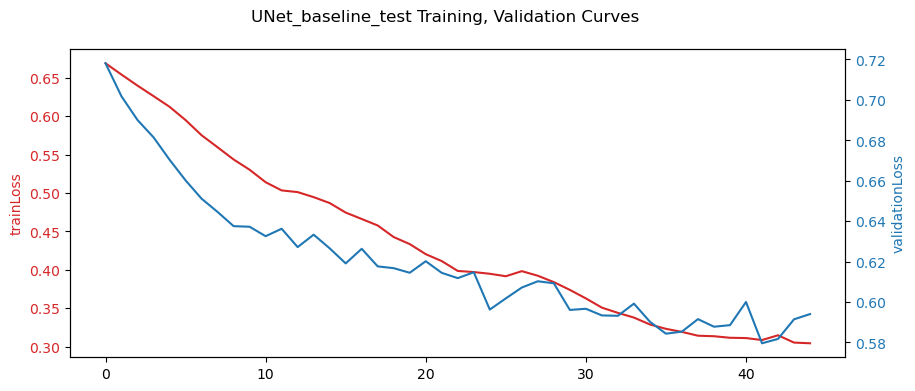

In [21]:
from utils import IoU
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

MODEL_NAME = 'UNet_baseline_'

# reference : https://smp.readthedocs.io/en/latest/losses.html
# criterion = smp.losses.DiceLoss('multiclass', log_loss = True, smooth=1.0)
criterion = smp.losses.JaccardLoss('multiclass', log_loss = False, smooth=0.0)

# MODEL HYPERPARAMETERS
N_EPOCHS = 70
NUM_CLASSES = 6
MAX_LR = 3e-4
# MODEL_NAME = 'UNet_baseline_jaccardloss'

# create model, optimizer, lr_scheduler and pass to training function
model = UNet(in_channels=3, out_channels=NUM_CLASSES, layer_channels=[64, 128, 256, 512]).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS, steps_per_epoch = len(train_loader), 
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

subset_loader1 = DataLoader(torch.utils.data.Subset(train_dataset, range(20)), batch_size=1, shuffle=False)
subset_loader2 = DataLoader(torch.utils.data.Subset(valid_dataset, range(20)), batch_size=1, shuffle=False)


# _ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer, 
#                          device, train, subset_loader2, IoU, 'metrices',
#                          NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

## Continue Training

In [21]:
MODEL_NAME = 'UNet_baseline_jaccardloss_noScheduler'
MODEL_PATH = os.path.join(output_path, MODEL_NAME+'_general.pt')

N_EPOCHS = 2

metrices = IoU

criterion = smp.losses.JaccardLoss('multiclass', log_loss = False, smooth=0.0)

# model = UNet(in_channels=3, out_channels=NUM_CLASSES, layer_channels=[64, 128, 256, 512]).to(device) 
# optimizer = optim.Adam(model.parameters(), lr=MAX_LR)

checkpoint = torch.load(MODEL_PATH)
# model.load_state_dict(checkpoint['model_state_dict'])

# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# checkpoint = torch.load(MODEL_PATH)
model_ = checkpoint['model']
optimizer_ = checkpoint['optimizer']
scheduler_ = checkpoint['lr_scheduler']
# scheduler = OneCycleLR(optimizer_, max_lr= MAX_LR, epochs = N_EPOCHS, steps_per_epoch = len(train_loader), 
#                        pct_start=0.3, div_factor=10, anneal_strategy='cos')
# steps = N_EPOCHS * len(train_loader)
# scheduler_.state_dict()['_schedule_phases'][1]['end_step'] += steps
# scheduler_.state_dict()['total_steps'] += steps
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])


# _ = train_validate_model(model_, N_EPOCHS, MODEL_NAME, criterion, optimizer_, 
#                          device, train_loader, valid_loader, IoU, 'metrices',
#                          NUM_CLASSES, lr_scheduler = None, output_path = output_path, results = checkpoint['results'])

Starting 7 epoch ...


  1%|          | 8/1008 [00:02<05:54,  2.82it/s]


KeyboardInterrupt: 

In [ ]:
!pip install torchstat

In [ ]:
MODEL_NAME = 'UNet_baseline_test
MODEL_PATH = os.path.join(output_path,MODEL_NAME, MODEL_NAME+'_epoch_4.pt')
print(MODEL_PATH)
# model_jacc = UNet(in_channels=3, out_channels=NUM_CLASSES, layer_channels=[64, 128, 256, 512]).to(device) 

checkpoint_jacc = torch.load(MODEL_PATH)
# model_jacc.load_state_dict(checkpoint_jacc['model_state_dict'])

print(checkpoint_jacc['results'])

In [21]:
test_loader = DataLoader(torch.utils.data.Subset(test_dataset, range(1)), batch_size=1, shuffle=False)
# torch.set_printoptions(threshold=2000)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_loader, criterion, metrices, NUM_CLASSES, device)
# print(f"\nModel has {test_metric[0]} IoU per class and {test_metric[1]} mean IoU in test set")
print(test_metric)

100%|██████████| 1/1 [00:05<00:00,  5.04s/it]

{'hist': array([[1.30000e+01, 1.00000e+02, 6.38000e+02, 7.26000e+02, 0.00000e+00,
        0.00000e+00],
       [1.25300e+03, 1.89392e+05, 7.43000e+02, 4.00000e+00, 2.00000e+00,
        1.26900e+03],
       [8.26700e+03, 4.31900e+03, 3.01120e+04, 1.74560e+04, 0.00000e+00,
        1.42600e+03],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 1.68300e+03, 0.00000e+00,
        0.00000e+00],
       [0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00],
       [4.85000e+02, 8.20000e+01, 7.50000e+02, 6.51000e+02, 6.00000e+01,
        2.71300e+03]]), 'accuracy': 0.8541603088378906, 'classwise_accuracy': array([0.00880162, 0.98302217, 0.48898993, 1.        ,        nan,
       0.57224214]), 'miou': 0.31353528678039333, 'classwise_iou': array([0.00113221, 0.96058104, 0.47263424, 0.08201754, 0.        ,
       0.36484669])}



/home/j/j_sten07/thesis_test/Semantic-Segmentation-using-Deep-Learning/finalContent/utils.py:254: RuntimeWarning: invalid value encountered in divide
  class_accuracy = np.diag(hist) / hist.sum(axis = 1)


# 4. Evaluate : Evaluate the model on Test Data and visualize results 

In [23]:
MODEL_PATH = os.path.join(output_path,MODEL_NAME, MODEL_NAME+'_best.pt')
checkpoint = torch.load(MODEL_PATH)
model = checkpoint['model']
# model.to(device)
# model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
_, test_metric = evaluate_model(model, test_loader, criterion, IoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} metrices in test set")

100%|██████████| 720/720 [05:53<00:00,  2.04it/s]


Model has {'accuracy': 0.8295776685078938, 'classwise_accuracy': array([0.87989761, 0.94131838, 0.84491766, 0.75591747, 0.84802608,
       0.2946083 ]), 'miou': 0.6604745669066363, 'classwise_iou': array([0.74017368, 0.84072241, 0.68991748, 0.68550452, 0.78843009,
       0.21809922])} IoU in test set


In [24]:
from utils import visualize_predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


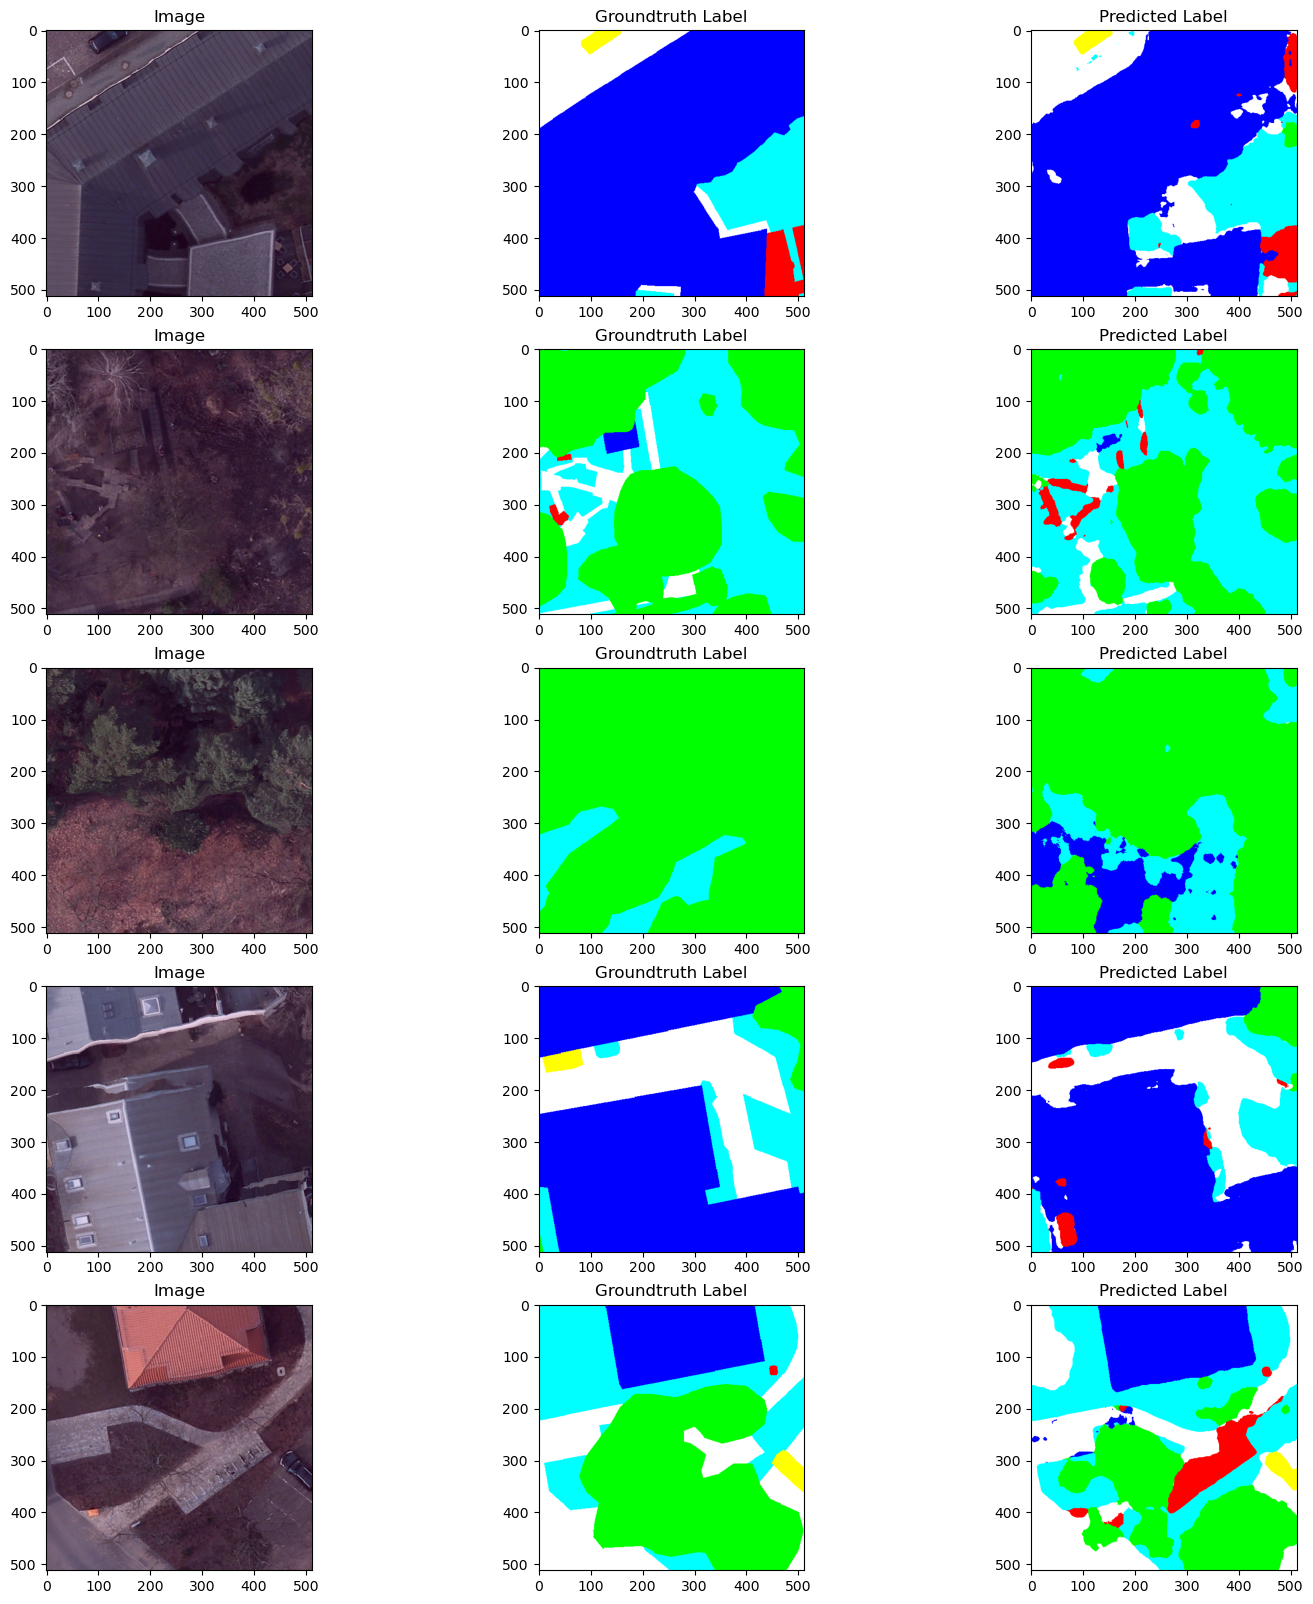

In [27]:
num_test_samples = 5
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_dataset, axes, device, numTestSamples=num_test_samples, id_to_color=train_id_to_color)